In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import re

In [2]:
df1_chunks = pd.read_csv("ga_hits.csv", chunksize=500000)  
df1 = pd.concat(df1_chunks, ignore_index=True) 
df2 = pd.read_csv("ga_sessions.csv", low_memory=False)

# Загрузка Pickle
df_sessions = pd.read_pickle("ga_sessions.pkl")
df_hits = pd.read_pickle("ga_hits.pkl")

In [3]:
print("CSV 1:", df1.shape, "\n", df1.head())
print("CSV 2:", df2.shape, "\n", df2.head())
print("Sessions:", df_sessions.shape, "\n", df_sessions.head())
print("Hits:", df_hits.shape, "\n", df_hits.head())


CSV 1: (15726470, 11) 
                                   session_id    hit_date  hit_time  \
0  5639623078712724064.1640254056.1640254056  2021-12-23  597864.0   
1  7750352294969115059.1640271109.1640271109  2021-12-23  597331.0   
2   885342191847998240.1640235807.1640235807  2021-12-23  796252.0   
3   142526202120934167.1640211014.1640211014  2021-12-23  934292.0   
4  3450086108837475701.1640265078.1640265078  2021-12-23  768741.0   

   hit_number hit_type hit_referer  \
0          30    event         NaN   
1          41    event         NaN   
2          49    event         NaN   
3          46    event         NaN   
4          79    event         NaN   

                                       hit_page_path event_category  \
0  sberauto.com/cars?utm_source_initial=google&ut...           quiz   
1  sberauto.com/cars/fiat?city=1&city=18&rental_c...           quiz   
2  sberauto.com/cars/all/volkswagen/polo/e994838f...           quiz   
3  sberauto.com/cars?utm_source_initial=ya

In [4]:
print("Sessions columns:", df_sessions.columns)
print("Hits columns:", df_hits.columns)


Sessions columns: Index(['session_id', 'client_id', 'visit_date', 'visit_time', 'visit_number',
       'utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent',
       'utm_keyword', 'device_category', 'device_os', 'device_brand',
       'device_model', 'device_screen_resolution', 'device_browser',
       'geo_country', 'geo_city'],
      dtype='object')
Hits columns: Index(['session_id', 'hit_date', 'hit_time', 'hit_number', 'hit_type',
       'hit_referer', 'hit_page_path', 'event_category', 'event_action',
       'event_label', 'event_value'],
      dtype='object')


In [5]:
# Проверяем пропущенные значения
print("Пропуски в ga_sessions.csv:\n", df2.isnull().sum())
print("\nПропуски в ga_hits.csv:\n", df1.isnull().sum())

# Проверяем дубликаты
print("\nДубликаты в ga_sessions.csv:", df2.duplicated().sum())
print("Дубликаты в ga_hits.csv:", df1.duplicated().sum())

# Проверяем типы данных
print("\nТипы данных в ga_sessions.csv:\n", df2.dtypes)
print("\nТипы данных в ga_hits.csv:\n", df1.dtypes)


Пропуски в ga_sessions.csv:
 session_id                        0
client_id                         0
visit_date                        0
visit_time                        0
visit_number                      0
utm_source                       97
utm_medium                        0
utm_campaign                 219603
utm_adcontent                335615
utm_keyword                 1082061
device_category                   0
device_os                   1070138
device_brand                 367178
device_model                1843704
device_screen_resolution          0
device_browser                    0
geo_country                       0
geo_city                          0
dtype: int64

Пропуски в ga_hits.csv:
 session_id               0
hit_date                 0
hit_time           9160322
hit_number               0
hit_type                 0
hit_referer        6274804
hit_page_path            0
event_category           0
event_action             0
event_label        3760184
event_value   

In [6]:
# --- Обрабатываем ga_sessions.csv ---
df2['visit_date'] = pd.to_datetime(df2['visit_date'])  # Преобразуем в datetime
df2 = df2.assign(
    utm_source=df2['utm_source'].fillna('unknown'),
    utm_campaign=df2['utm_campaign'].fillna('unknown'),
    utm_adcontent=df2['utm_adcontent'].fillna('unknown'),
    utm_keyword=df2['utm_keyword'].fillna('unknown'),
    device_os=df2['device_os'].fillna('unknown'),
    device_brand=df2['device_brand'].fillna('unknown')
)
# Проверяем, есть ли столбец, и только потом удаляем
if 'device_model' in df2.columns:
    df2.drop(columns=['device_model'], inplace=True)

# --- Обрабатываем ga_hits.csv ---
df1['hit_date'] = pd.to_datetime(df1['hit_date'])  # Преобразуем в datetime
df1 = df1.assign(
    hit_time=df1['hit_time'].fillna(0),
    hit_referer=df1['hit_referer'].fillna('unknown'),
    event_label=df1['event_label'].fillna('unknown')
)
# Проверяем, есть ли столбец, и только потом удаляем
if 'event_value' in df1.columns:
    df1.drop(columns=['event_value'], inplace=True)

# Проверяем результат
print("После обработки пропусков:")
print("Пропуски в ga_sessions.csv:\n", df2.isnull().sum())
print("\nПропуски в ga_hits.csv:\n", df1.isnull().sum())


После обработки пропусков:
Пропуски в ga_sessions.csv:
 session_id                  0
client_id                   0
visit_date                  0
visit_time                  0
visit_number                0
utm_source                  0
utm_medium                  0
utm_campaign                0
utm_adcontent               0
utm_keyword                 0
device_category             0
device_os                   0
device_brand                0
device_screen_resolution    0
device_browser              0
geo_country                 0
geo_city                    0
dtype: int64

Пропуски в ga_hits.csv:
 session_id        0
hit_date          0
hit_time          0
hit_number        0
hit_type          0
hit_referer       0
hit_page_path     0
event_category    0
event_action      0
event_label       0
dtype: int64


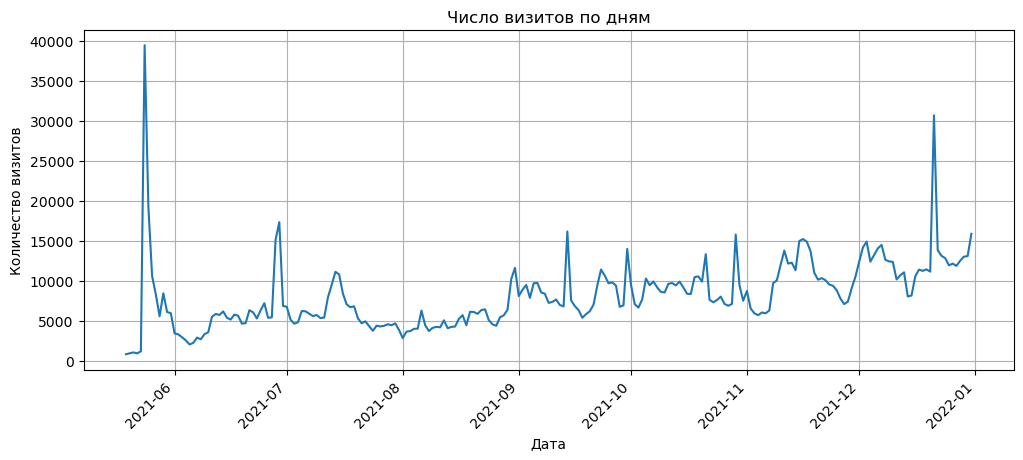

In [7]:
#Изменения число посещений сайта
plt.figure(figsize=(12, 5))
df2['visit_date'].value_counts().sort_index().plot()
plt.title("Число визитов по дням")
plt.xlabel("Дата")
plt.ylabel("Количество визитов")
plt.xticks(rotation=45)
plt.grid()
plt.show()

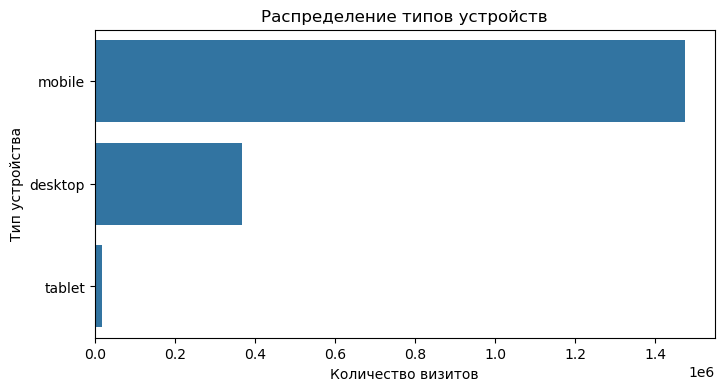

In [8]:
#Какие устройства используют пользователи
plt.figure(figsize=(8,4))
sns.countplot(y=df2["device_category"], order=df2["device_category"].value_counts().index)
plt.title("Распределение типов устройств")
plt.xlabel("Количество визитов")
plt.ylabel("Тип устройства")
plt.show()

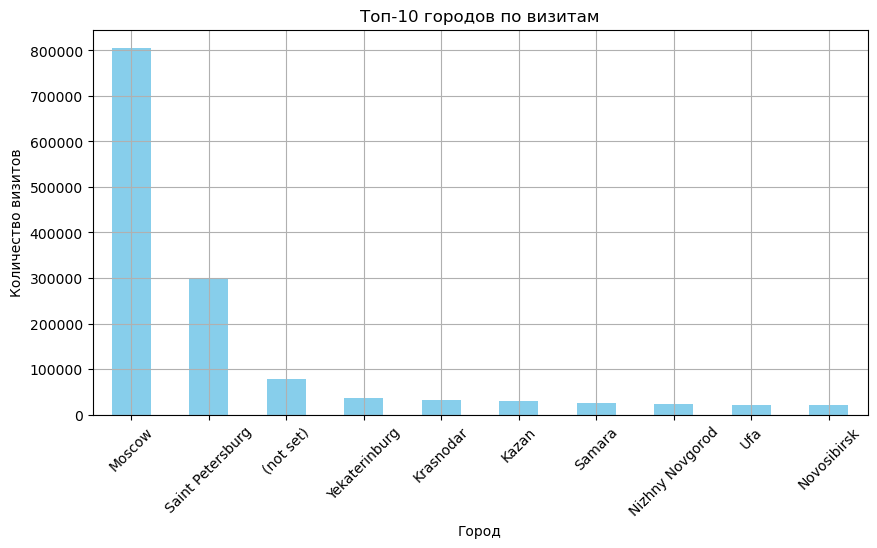

In [9]:
#Топ-10 городов по числу визитов
plt.figure(figsize=(10,5))
df2['geo_city'].value_counts().nlargest(10).plot(kind='bar', color='skyblue')
plt.title("Топ-10 городов по визитам")
plt.xlabel("Город")
plt.ylabel("Количество визитов")
plt.xticks(rotation=45)
plt.grid()
plt.show()

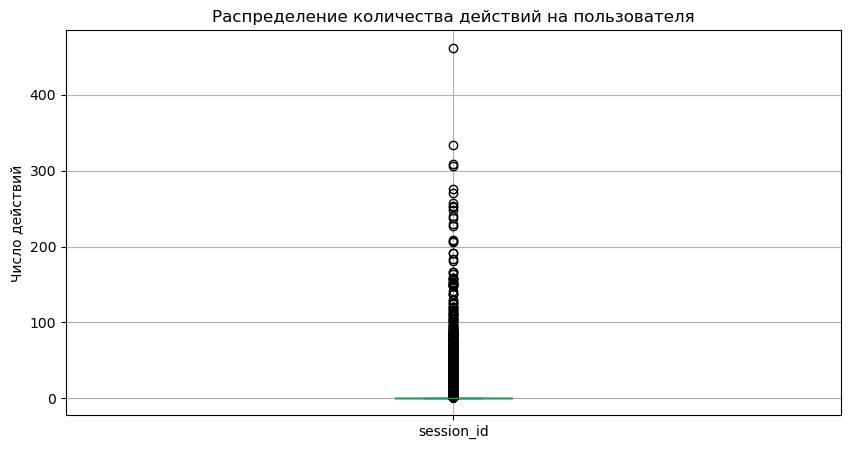

In [10]:
#Проверка на выбросы
plt.figure(figsize=(10,5))
df2.groupby("client_id")["session_id"].count().plot(kind='box')
plt.title("Распределение количества действий на пользователя")
plt.ylabel("Число действий")
plt.grid()
plt.show()


In [11]:
df2.groupby("client_id")["session_id"].count().describe()


count    1.391719e+06
mean     1.336507e+00
std      1.909020e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      4.620000e+02
Name: session_id, dtype: float64

In [12]:
#Анализ выбросов
df_anomalies = df2.groupby("client_id")["session_id"].count().reset_index()
df_anomalies = df_anomalies[df_anomalies["session_id"] > 10]
print(df_anomalies.describe())


        session_id
count  4187.000000
mean     21.487222
std      24.079380
min      11.000000
25%      12.000000
50%      15.000000
75%      21.000000
max     462.000000


In [13]:
#Фильтровать пользователей, у кого > 100 сессий
df_clean = df2.groupby("client_id")["session_id"].count()
df_clean = df_clean[df_clean <= 100]  # Оставляем только "реальных" пользователей


In [14]:
target_events = [
    "sub_car_claim_click", "sub_car_claim_submit_click", 
    "sub_open_dialog_click", "sub_custom_question_submit_click", 
    "sub_call_number_click", "sub_callback_submit_click", 
    "sub_submit_success", "sub_car_request_submit_click"
]

if "event_action" in df1.columns:
    df1["is_target"] = df1["event_action"].isin(target_events).astype(int)
else:
    print("Ошибка: В df1 нет колонки 'event_action'!")

target_sessions = df1.groupby("session_id", as_index=False)["is_target"].sum()
print("Переменная target_sessions успешно создана!")


Переменная target_sessions успешно создана!


In [15]:
df2 = df2.merge(target_sessions[['session_id', 'is_target']], on="session_id", how="left")
df2["is_target"] = df2["is_target"].fillna(0)


In [16]:
df2["traffic_type"] = df2["utm_medium"].apply(lambda x: "organic" if x in ["organic", "referral", "(none)"] else "paid")

cr_organic = df2[df2["traffic_type"] == "organic"]["is_target"].mean()
cr_paid = df2[df2["traffic_type"] == "paid"]["is_target"].mean()

print(f"CR (органический трафик): {cr_organic:.4f}")
print(f"CR (платный трафик): {cr_paid:.4f}")


CR (органический трафик): 0.0808
CR (платный трафик): 0.0455


In [17]:
organic_cr = df2[df2["traffic_type"] == "organic"]["is_target"]
paid_cr = df2[df2["traffic_type"] == "paid"]["is_target"]

t_stat, p_value = ttest_ind(organic_cr, paid_cr, equal_var=False)

print(f"T-статистика: {t_stat:.4f}")
print(f"P-значение: {p_value:.4f}")

if p_value < 0.05:
    print("Различие значимо (отвергаем H₀)")
else:
    print("Различие незначимо (не отвергаем H₀)")

T-статистика: 38.4917
P-значение: 0.0000
Различие значимо (отвергаем H₀)


In [18]:
cr_mobile = df2[df2["device_category"] == "mobile"]["is_target"].mean()
cr_desktop = df2[df2["device_category"] == "desktop"]["is_target"].mean()

print(f"CR (мобильные): {cr_mobile:.4f}")
print(f"CR (десктоп): {cr_desktop:.4f}")


CR (мобильные): 0.0521
CR (десктоп): 0.0688


In [19]:
mobile_cr = df2[df2["device_category"] == "mobile"]["is_target"]
desktop_cr = df2[df2["device_category"] == "desktop"]["is_target"]

t_stat, p_value = ttest_ind(mobile_cr, desktop_cr, equal_var=False)

print(f"T-статистика: {t_stat:.4f}")
print(f"P-значение: {p_value:.4f}")

if p_value < 0.05:
    print("Различие значимо (отвергаем H₀)")
else:
    print("Различие незначимо (не отвергаем H₀)")


T-статистика: -14.8714
P-значение: 0.0000
Различие значимо (отвергаем H₀)


In [20]:
df2["region_type"] = df2["geo_city"].apply(lambda x: "Москва/СПб" if x in ["Moscow", "Saint Petersburg"] else "Другие")

cr_moscow_spb = df2[df2["region_type"] == "Москва/СПб"]["is_target"].mean()
cr_other = df2[df2["region_type"] == "Другие"]["is_target"].mean()

print(f"CR (Москва/СПб): {cr_moscow_spb:.4f}")
print(f"CR (Другие регионы): {cr_other:.4f}")


CR (Москва/СПб): 0.0590
CR (Другие регионы): 0.0499


In [21]:
moscow_spb_cr = df2[df2["region_type"] == "Москва/СПб"]["is_target"]
other_cr = df2[df2["region_type"] == "Другие"]["is_target"]

t_stat, p_value = ttest_ind(moscow_spb_cr, other_cr, equal_var=False)

print(f"T-статистика: {t_stat:.4f}")
print(f"P-значение: {p_value:.4f}")

if p_value < 0.05:
    print("Различие значимо (отвергаем H₀)")
else:
    print("Различие незначимо (не отвергаем H₀)")


T-статистика: 11.4224
P-значение: 0.0000
Различие значимо (отвергаем H₀)


In [23]:
def extract_car_brand(path):
    match = re.search(r'/cars/all/([^/]+)', str(path))  # Ищем название после "/cars/all/"
    return match.group(1) if match else "unknown"

# Применяем функцию ко всем строкам в df1
df1["car_brand"] = df1["hit_page_path"].apply(extract_car_brand)

# Проверяем, какие марки авто встречаются чаще всего
popular_brands = df1["car_brand"].value_counts().reset_index()
popular_brands.columns = ["car_brand", "count"]
print("ТОП-10 популярных марок автомобилей:")
print(popular_brands.head(10))

# Считаем CR по маркам автомобилей
car_cr = df1.groupby("car_brand")["is_target"].mean().reset_index()
car_cr.columns = ["car_brand", "conversion_rate"]

# Выводим топ-10 авто с лучшим CR
print("\nТОП-10 марок с лучшим Conversion Rate:")
print(car_cr.sort_values(by="conversion_rate", ascending=False).head(10))

ТОП-10 популярных марок автомобилей:
       car_brand     count
0        unknown  12311655
1          skoda    744516
2  mercedes-benz    472316
3     volkswagen    417128
4       lada-vaz    403910
5         nissan    238701
6            kia    236270
7            bmw    195404
8         toyota    160840
9        renault    150656

ТОП-10 марок с лучшим Conversion Rate:
     car_brand  conversion_rate
5     infiniti         0.085308
4      hyundai         0.024457
3        honda         0.017632
7     lada-vaz         0.013260
19  volkswagen         0.012121
6          kia         0.011576
2        haval         0.011293
16       skoda         0.011096
17      toyota         0.010339
15     renault         0.009664
